In [1]:
import numpy
import matplotlib
from matplotlib import pyplot
import pickle
import pandas
import scipy
import seaborn
import tensorflow

from sklearn import preprocessing

import tensorflow.keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras import regularizers

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'

In [3]:
# Helper functions
def one_hot_encode(sequences, seq_len=100):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],
             'c':[0,1,0,0],
             'g':[0,0,1,0],
             't':[0,0,0,1],
             'n':[0,0,0,0]}
    
    # Creat empty matrix
    vectors = numpy.empty([len(sequences), seq_len, 4])
    
    # Iterate through sequences and one-hot encode
    for i, seq in enumerate(sequences): 
        seq = seq[:seq_len].lower()
        a = numpy.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
    return r_value**2

# Read data

669847 total sequences, 168279 retained.


,UTR,total,rl,error
0,ACATCGTAGAGAGTCGTACTTACCG,20252.0,5.584273,0.140398
1,AGAAGGTCGCGGCGTTTAGAATTCA,18955.0,6.683197,0.095390
2,AGAGATGAGCATTAAAATGGAACAA,12267.0,6.175643,0.139664
3,AGAGGATTTGAGGTTTTCGCATATT,11987.0,6.785426,0.158523
4,TCTACCGACGGTTAGTATTTATGCC,10255.0,6.548138,0.009790


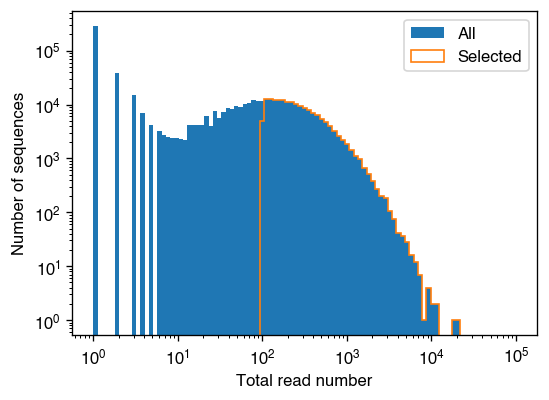

In [4]:
# Load 5'UTR data
data_full = pandas.read_csv('../polysome_profiling_data/random_end_hek293t_N25_combined.csv.gz')

# Preserve only sequences with largest number of reads
data_full.sort_values('total', inplace=True, ascending=False)
data_full.reset_index(inplace=True, drop=True)
data = data_full[data_full['total'] >= 100]

# Plot histogram with number of reads
pyplot.figure(figsize=(5, 3.5))
pyplot.hist(
    data_full['total'],
    bins=numpy.logspace(0, 5, 100),
    log=True,
    label='All')
pyplot.hist(
    data['total'],
    bins=numpy.logspace(0, 5, 100),
    log=True,
    label='Selected',
    histtype='step')
pyplot.xscale('log')
pyplot.xlabel('Total read number')
pyplot.ylabel('Number of sequences')
pyplot.legend()

print("{} total sequences, {} retained.".format(len(data_full), len(data)))

data.head()

In [5]:
# Separate into training and test subsets
data_test = data.iloc[:2000]
data_val = data.iloc[2000:4000]
data_train = data.iloc[4000:]

In [10]:
# Preprocess training data: one-hot encode input, scale output
data_train_x = one_hot_encode(data_train['UTR'], seq_len=25)
data_train_y = data_train.loc[:, 'rl'].values
# Shuffle training data
shuffle_index = numpy.arange(len(data_train_y))
numpy.random.shuffle(shuffle_index)
data_train_x = data_train_x[shuffle_index,:,:]
data_train_y = data_train_y[shuffle_index]

data_val_x = one_hot_encode(data_val['UTR'], seq_len=25)
data_val_y = data_val.loc[:, 'rl'].values

# Define and train model

In [11]:
# Define model
# Model parameters
input_len=25

# The following are first-attempt hyperparameters 
# conv_layers = 5
# conv_kernel_size = 3
# conv_filters_first = 64
# conv_dropout=0.2
# dense_units=40
# dense_dropout=0.2
# reg_lambda = 0.0

# The following are hyperparameters obtained from sagemaker hp optimization
conv_layers = 2
conv_kernel_size = 5
conv_filters_first = 128
conv_dropout=0.45
dense_units=18
dense_dropout=0.0
reg_lambda = 0.0

model = Sequential()
model.add(Input(shape=(input_len, 4)))

for conv_layer_idx in range(conv_layers):
    model.add(
        Conv1D(
            activation="relu",
            padding='same',
            filters=conv_filters_first*(2**conv_layer_idx),
            kernel_size=conv_kernel_size,
            name='conv_{}_0'.format(conv_layer_idx + 1),
            kernel_regularizer=regularizers.l2(reg_lambda),
        )
    )
    model.add(
        Conv1D(
            activation="relu",
            padding='same',
            filters=conv_filters_first*(2**conv_layer_idx),
            kernel_size=conv_kernel_size,
            name='conv_{}_1'.format(conv_layer_idx + 1),
            kernel_regularizer=regularizers.l2(reg_lambda),
        )
    )
    model.add(
        MaxPooling1D(
            pool_size=2,
            strides=2,
            padding='same',
        )
    )
    model.add(Dropout(conv_dropout))

model.add(Flatten())

model.add(
    Dense(
        dense_units,
        name='dense_1',
        activation='relu',
        kernel_regularizer=regularizers.l2(reg_lambda),
    )
)
model.add(Dropout(dense_dropout))

model.add(
    Dense(
        1,
        name='dense_2',
        activation='linear',
        kernel_regularizer=regularizers.l2(reg_lambda),
    )
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1_0 (Conv1D)           (None, 25, 128)           2688      
                                                                 
 conv_1_1 (Conv1D)           (None, 25, 128)           82048     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 13, 128)          0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 13, 128)           0         
                                                                 
 conv_2_0 (Conv1D)           (None, 13, 256)           164096    
                                                                 
 conv_2_1 (Conv1D)           (None, 13, 256)           327936    
                                                      

In [12]:
# Compile the model and train
epochs = 50
batch_size = 128
learning_rate = 0.001

steps_per_epoch = len(data_train_x)/batch_size

# Use decayed learning rate, half every 10 epochs
lr_schedule = tensorflow.keras.optimizers.schedules.InverseTimeDecay(
  learning_rate,
  decay_steps=steps_per_epoch*10,
  decay_rate=1,
  staircase=False)

# Callback: stop training after no improvement in validation
callbacks = [
    tensorflow.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
    ),
]

adam = tensorflow.keras.optimizers.Adam(lr_schedule)
model.compile(loss='mean_squared_error', optimizer=adam)

training_history = model.fit(
    data_train_x,
    data_train_y,
    validation_data=(data_val_x, data_val_y),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    sample_weight=5/(5 + data_train_y),
    verbose=1)

Epoch 1/50
1284/1284 [==============================] - 12s 6ms/step - loss: 0.5537 - val_loss: 0.9066
Epoch 2/50
1284/1284 [==============================] - 8s 6ms/step - loss: 0.3242 - val_loss: 0.5043
Epoch 3/50
1284/1284 [==============================] - 7s 5ms/step - loss: 0.2989 - val_loss: 0.3298
Epoch 4/50
1284/1284 [==============================] - 7s 5ms/step - loss: 0.2855 - val_loss: 0.3081
Epoch 5/50
1284/1284 [==============================] - 7s 5ms/step - loss: 0.2757 - val_loss: 0.3106
Epoch 6/50
1284/1284 [==============================] - 8s 6ms/step - loss: 0.2688 - val_loss: 0.2776
Epoch 7/50
1284/1284 [==============================] - 11s 9ms/step - loss: 0.2623 - val_loss: 0.2784
Epoch 8/50
1284/1284 [==============================] - 11s 8ms/step - loss: 0.2569 - val_loss: 0.2796
Epoch 9/50
1284/1284 [==============================] - 11s 8ms/step - loss: 0.2522 - val_loss: 0.2756
Epoch 10/50
1284/1284 [==============================] - 10s 8ms/step - loss: 

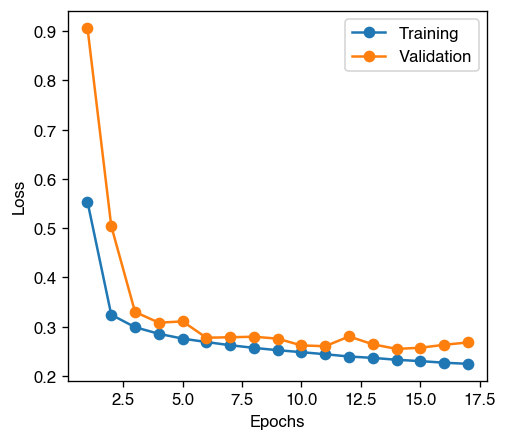

In [13]:
# Plot training/validation losses
f, ax = pyplot.subplots(1, 1, figsize=(4.5, 4))
n_epochs_actual = len(training_history.history['loss'])

ax.plot(
    numpy.arange(1, n_epochs_actual + 1),
    training_history.history['loss'],
    marker='o',
    label='Training',
)
ax.plot(
    numpy.arange(1, n_epochs_actual + 1),
    training_history.history['val_loss'],
    marker='o',
    label='Validation',
)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()

In [15]:
# Save model
# model.save('model_optimus5p_25.h5')

# Evaluate model

In [16]:
# Load model, process test data, plot
model = tensorflow.keras.models.load_model('model_optimus5p_25.h5')

In [17]:
# Generate predictions for the whole test dataset
data_test_x = one_hot_encode(data_test['UTR'], seq_len=25)
data_test_pred = model.predict(data_test_x)

# Calculate overall R^2
R2 = r2(data_test_pred.reshape(-1), data_test['rl'].values)
print("R^2 = {:.4f}".format(R2))

R^2 = 0.8055


No uAUG      1254
With uAUG     746
Name: uATG string, dtype: int64


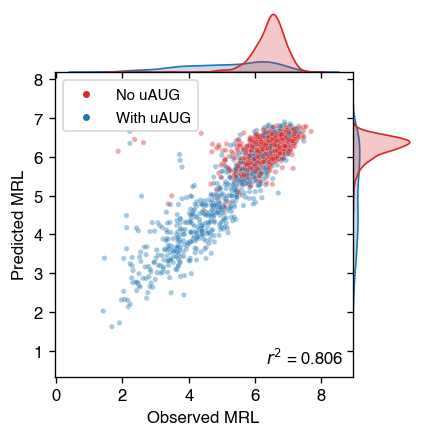

In [18]:
data_to_plot = data_test.copy()
# Add prediction
data_to_plot['rl_pred'] = data_test_pred
# Assign whether uAUGs are present in the sequence
data_to_plot['uATG'] = data_to_plot['UTR'].str.contains('ATG')
data_to_plot.loc[data_to_plot['uATG'], 'uATG string'] = 'With uAUG'
data_to_plot.loc[~data_to_plot['uATG'], 'uATG string'] = 'No uAUG'
# Randomize order
data_to_plot = data_to_plot.sample(frac=1)

print(data_to_plot['uATG string'].value_counts())

uaug_colors = {True: 'tab:blue', False: 'tab:red'}

g = seaborn.JointGrid(
    data=data_to_plot,
    x="rl",
    y="rl_pred",
    hue="uATG string",
    palette={'With uAUG': 'tab:blue', 'No uAUG': 'tab:red'},
    height=3.75,
    space=.0,
)
g.plot_joint(seaborn.scatterplot, s=10, alpha=.4, rasterized=True)
g.plot_marginals(seaborn.kdeplot, fill=True,)

g.ax_joint.set_xlabel('Observed MRL')
g.ax_joint.set_ylabel('Predicted MRL')
leg = g.ax_joint.legend(loc='upper left')
for lh in leg.legendHandles: 
    lh.set_sizes([10])
for text in leg.texts:
    text.set_fontsize(9)

xlim = g.ax_joint.get_xlim()
ylim = g.ax_joint.get_ylim()
xpos = xlim[0] + 0.97*(xlim[1] - xlim[0])
ypos = ylim[0] + 0.04*(ylim[1] - ylim[0])
g.ax_joint.text(xpos, ypos, f'$r^2$ = {R2:.3f}', ha='right')

g.fig.savefig('test_rand-n25.svg', dpi=200, bbox_inches='tight')
g.fig.savefig('test_rand-n25.png', dpi=200, bbox_inches='tight')